In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import math as m
from scipy.stats import pearsonr
from scipy.spatial.distance import correlation as dcorr

In [29]:
inflation = pd.read_csv('Price_index.csv',index_col = 0)

inflation.columns = ['price']
inflation['delta'] = ((inflation['price'] - inflation['price'].shift(12))/inflation['price']) * 100
inflation = inflation.loc['1976-01-01':'2017-03-01']
#print(inflation)


#plt.figure(1)
#inflation['delta'].plot()
#plt.show()

m2 = pd.read_csv('M2_USA.csv', index_col = 0)
m2.columns = ['M2']
m2['M2'] = m2['M2'] / 1000000000

savings = pd.read_csv('SAVINGSL.csv', index_col = 0)
savings.columns = ['Savings']
print(savings)

rapport = m2['M2']/savings['Savings']
difference = m2['M2'] - savings['Savings']
delta_difference = ((difference - difference.shift(12))/difference) * 100

rapport = pd.DataFrame(rapport)
rapport = rapport.loc['1976-01-01':'2017-03-01']
delta_difference = pd.DataFrame(delta_difference)
delta_difference = delta_difference.loc['1976-01-01':'2017-03-01']


## Je m'assure du type de données ##
inflation.astype(dtype = 'float')
rapport.astype(dtype = 'float')
delta_difference.astype(dtype = 'float')

delta_difference.columns=['M2_less_savings']

            Savings
DATE               
1970-01-01    262.7
1970-02-01    257.9
1970-03-01    254.5
1970-04-01    251.4
1970-05-01    250.1
...             ...
2016-11-01   8765.2
2016-12-01   8814.5
2017-01-01   8849.9
2017-02-01   8902.8
2017-03-01   8922.1

[567 rows x 1 columns]


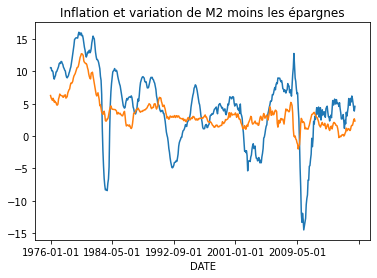

In [30]:
plt.figure()
delta_difference['M2_less_savings'].plot()
inflation['delta'].plot()
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

<Figure size 432x288 with 0 Axes>

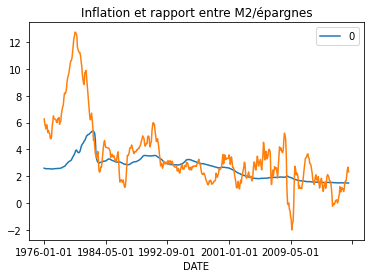

In [31]:
plt.figure()
rapport.plot()
inflation['delta'].plot()
plt.title('Inflation et rapport entre M2/épargnes')
plt.show()

In [32]:
############# Analyse statistique de base #############

## inlfation et delta différence entre 1976 et 2017 ##

x1 = inflation['delta'].values
y1 = delta_difference['M2_less_savings'].values

coeff_pearson = pearsonr(x1,y1)
print("coefficient de Pearson = {}".format(coeff_pearson))

coefficient de Pearson = (0.6141310647672451, 1.2020602172269806e-52)


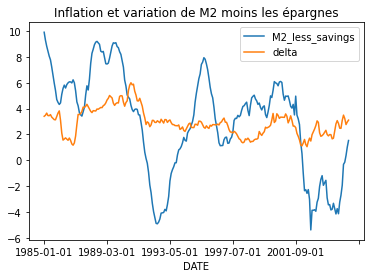

In [33]:
## inlfation et delta différence entre 1985 et 2005 ##

delta_difference_1985 = delta_difference.loc['1985-01-01':'2005-03-01']
inflation_1985 = inflation.loc['1985-01-01':'2005-03-01']

plt.figure()
delta_difference_1985['M2_less_savings'].plot(legend='M2 moins épargnes')
inflation_1985['delta'].plot(legend='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

In [34]:
############# Analyse statistique de base #############

x2 = inflation_1985['delta'].values
y2 = delta_difference_1985['M2_less_savings'].values

coeff_pearson = pearsonr(x2,y2)
print("coefficient de Pearson entre 1985 et 2005 = {}".format(coeff_pearson))

# Entre 1983 et 2001 on obtient : coefficient de Pearson = (0.2661862613252829, 6.639230681995491e-05)

coefficient de Pearson entre 1985 et 2005 = (0.3744243609646771, 1.667439706937323e-09)


In [35]:
######### Analyse stat avec dcorr (distance correlation) #########

x3 = inflation_1985['delta'].values
y3 = delta_difference_1985['M2_less_savings'].values

correlation = dcorr(x3,y3)

print(correlation)

0.6255756390353229


# Étude Tau linéaire

In [56]:
def T(a,b,x):
    return a*x+b

## Étude de tau sur les séries standardisées

In [57]:
## Je vais utiliser les dataframe de 1981 à 2007 pour être large puis je vais couper entre 1983 et 2001

delta_difference_1983_2001_standard = delta_difference.loc['1984-03-01':'2001-03-01']
inflation_1983_2007 = inflation.loc['1984-03-01':'2007-03-01']

scaler = StandardScaler()

In [58]:
### Construction du T idéal pour un décalage croissant ###

values = delta_difference_1983_2001_standard['M2_less_savings'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard['M2_less_savings'].values # Préparer les données
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.reshape((len(values), 1))
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.tolist()

for j in range(len(delta_difference_1983_2001_standard_values)):     
            delta_difference_1983_2001_standard_values[j] = delta_difference_1983_2001_standard_values[j][0]  # Mise au bon format

R_best_standard = 0
Solution_ideale_standard = [0,0,0]
Meilleurs_solutions_standard = []
inflation_shift_ideale_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]
Liste_1=[]

A = [0.005*a for a in range(0,31)]

for b in range(0,37):
    L=[]

    for a in A:
        infla_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

        for i in range(len(delta_difference_1983_2001_standard_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla_standard[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        values = np.array(infla_standard)
        values = values.reshape((len(values), 1))
        scaler = scaler.fit(values)
        infla_standard = scaler.transform(values) #Standardisation de infla_standard
        infla_standard = infla_standard.tolist()

        for j in range(len(infla_standard)) :     # Mise au bon format
            infla_standard[j] = infla_standard[j][0]

        R = pearsonr(infla_standard,delta_difference_1983_2001_standard_values)
        
        if abs(R[0]) > 0.4 :
            Meilleurs_solutions_standard.append([a,b,R])

        if abs(R[0]) > abs(R_best_standard) :
            Solution_ideale_standard = [a,b,R]
            R_best_standard = R[0]
            inflation_shift_ideale_standard = infla_standard
        
        L.append(R[0])

    Liste_1.append(L)


print(Solution_ideale_standard)
#print(Meilleurs_solutions_standard)

<ipython-input-58-f420c060b7f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M
[0.135, 2, (0.4627379651845429, 2.8389772974807263e-12)]


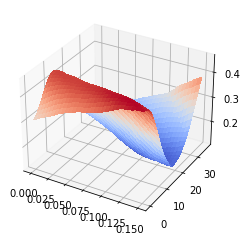

In [59]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X=A
Y=[b for b in range(0,37)]
X, Y = np.meshgrid(X, Y)
Z=Liste_1
Z=np.array(Z)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

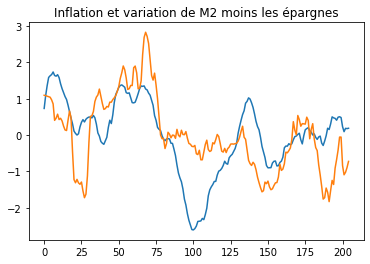

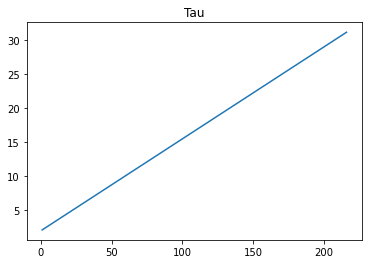

In [60]:
plt.figure()
plt.plot(delta_difference_1983_2001_standard_values,label='M')
plt.plot(inflation_shift_ideale_standard,label='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')

plt.figure()
X=[x for x in range(1,217)]
Y = []
for x in X:
    Y.append(T(0.135,2,x))
plt.plot(X,Y)
plt.title('Tau')
plt.show()

In [61]:
### Construction du T idéal pour un décalage décroissant ###

values = delta_difference_1983_2001_standard['M2_less_savings'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard['M2_less_savings'].values # Préparer les données
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.reshape((len(values), 1))
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.tolist()

for j in range(len(delta_difference_1983_2001_standard_values)):     
            delta_difference_1983_2001_standard_values[j] = delta_difference_1983_2001_standard_values[j][0]  # Mise au bon format

R_best_standard = 0
Solution_ideale_standard = [0,0,0]
Meilleurs_solutions_standard = []
inflation_shift_ideale_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]
Liste_2 = []

for b in range(0,49):
    L=[]
    A = [-x/240 for x in range(0,b+1)]

    for a in A:
        infla_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

        for i in range(len(delta_difference_1983_2001_standard_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla_standard[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        values = np.array(infla_standard)
        values = values.reshape((len(values), 1))
        scaler = scaler.fit(values)
        infla_standard = scaler.transform(values) #Standardisation de infla_standard
        infla_standard = infla_standard.tolist()

        for j in range(len(infla_standard)) :     # Mise au bon format
            infla_standard[j] = infla_standard[j][0]

        R = pearsonr(infla_standard,delta_difference_1983_2001_standard_values)
        
        if abs(R[0]) > 0.4 :
            Meilleurs_solutions_standard.append([a,b,R])

        if abs(R[0]) > abs(R_best_standard) :
            Solution_ideale_standard = [a,b,R]
            R_best_standard = R[0]
            inflation_shift_ideale_standard = infla_standard
        
        L.append(R[0])

    if b!=48 :
        for i in range(b+1,49):
            L.append(0)

    Liste_2.append(L)


print(Solution_ideale_standard)
#print(Meilleurs_solutions_standard)

<ipython-input-61-7b63338ef7c5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M
[-0.15, 36, (0.5233388856345553, 8.233062558260486e-16)]


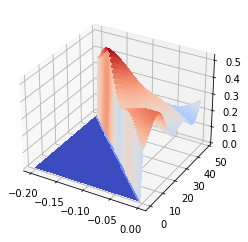

In [62]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X=A
Y=[b for b in range(0,49)]
X, Y = np.meshgrid(X, Y)
Z=Liste_2
Z=np.array(Z)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

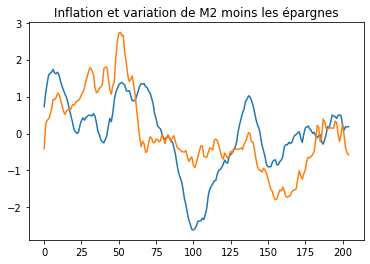

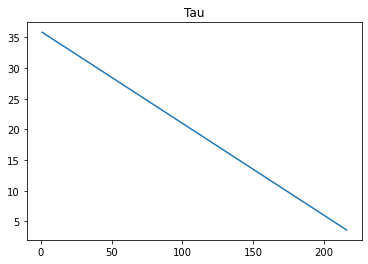

In [63]:
plt.figure()
plt.plot(delta_difference_1983_2001_standard_values,label='M')
plt.plot(inflation_shift_ideale_standard,label='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')

plt.figure()
X=[x for x in range(1,217)]
Y = []
for x in X:
    Y.append(T(-0.15,36,x))
plt.plot(X,Y)
plt.title('Tau')
plt.show()

# Étude de tau sur les séries non standardisées

In [44]:
delta_difference_1983_2001 = delta_difference.loc['1984-03-01':'2001-03-01']
inflation_1983_2007 = inflation.loc['1984-03-01':'2007-03-01']

In [45]:
### Construction du T idéal ###

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_values = delta_difference_1983_2001['M2_less_savings'].values # Préparer les données
delta_difference_1983_2001_values = delta_difference_1983_2001_values.reshape((len(values), 1))
delta_difference_1983_2001_values = delta_difference_1983_2001_values.tolist()

for j in range(len(delta_difference_1983_2001_values)):     
            delta_difference_1983_2001_values[j] = delta_difference_1983_2001_values[j][0]  # Mise au bon format

Meilleurs_solutions = []
R_best = 0
Solution_ideale = [0,0,0]
inflation_shift_ideale = [0 for x in range(len(delta_difference_1983_2001_values))]

A = [0.005*i for i in range(0,31)]

for a in A:
    for b in range(0,37):
        infla = [0 for x in range(len(delta_difference_1983_2001_values))]
        for i in range(len(delta_difference_1983_2001_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        infla = np.array(infla)
        infla = infla.reshape((len(values), 1))
        infla = infla.tolist()

        for j in range(len(infla)):     # Mise au bon format
            infla[j] = infla[j][0]

        R = pearsonr(infla,delta_difference_1983_2001_values)
        
        if abs(R[0]) > 0.4 :
            Meilleurs_solutions.append([a,b,R])

        if abs(R[0]) > abs(R_best):
            Solution_ideale = [a,b,R]
            R_best = R[0]
            inflation_shift_ideale = infla


print(Solution_ideale)
print(R_best)
print(Meilleurs_solutions)

[0.135, 2, (0.46273796518454285, 2.8389772974807263e-12)]
0.46273796518454285
[[0.0, 7, (0.40354925388143287, 1.9765276412089106e-09)], [0.0, 8, (0.41623077776939377, 5.399124781887972e-10)], [0.0, 9, (0.4260634335552232, 1.9005541150808505e-10)], [0.0, 10, (0.43240432424135206, 9.519669862455171e-11)], [0.0, 11, (0.4346779183727988, 7.403490214267067e-11)], [0.0, 12, (0.43191531052833954, 1.004616151950335e-10)], [0.0, 13, (0.4245296363016381, 2.2417067162080962e-10)], [0.0, 14, (0.40959735998983604, 1.0716627673103796e-09)], [0.005, 7, (0.4129575491690733, 7.586683555816449e-10)], [0.005, 8, (0.4239516717181676, 2.385079706600365e-10)], [0.005, 9, (0.4315221929590294, 1.0489791509972257e-10)], [0.005, 10, (0.43562020728085526, 6.667248415650239e-11)], [0.005, 11, (0.43699458067932484, 5.71934353774167e-11)], [0.005, 12, (0.4339965774142158, 7.984391380060494e-11)], [0.005, 13, (0.42270536692178307, 2.725134559694027e-10)], [0.005, 14, (0.40471586565564, 1.7580742053008974e-09)], [0.0

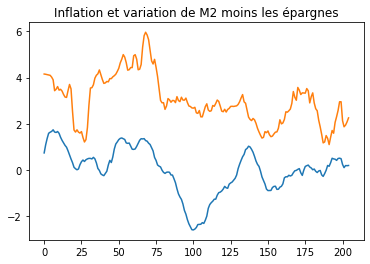

In [46]:
plt.figure()
plt.plot(delta_difference_1983_2001_values,label='M')
plt.plot(inflation_shift_ideale,label='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

# Étude avec Tau log

## Étude de tau sur les séries standardisées

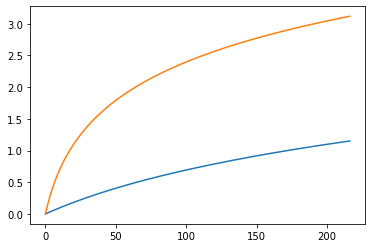

In [47]:
plt.figure()
X = [x for x in range(0,217)]
Y=[]
for x in X:
    Y.append(m.log(0.01*x+1))
plt.plot(X,Y)
Y=[]
for x in X:
    Y.append(m.log(0.1*x+1))
plt.plot(X,Y)
plt.show()

### a va de 0.001 à 0.1 par pas de 0.001 soit 100 valeurs

In [48]:
print(m.exp(3))   ### b va de 1 à 20
print(m.log(1.17)*12)

20.085536923187668
1.8840449857159762


In [49]:
def T(a,b,x):
    return(12*(m.log(a*x+b)))

In [50]:
###### Standardization de la série temporelle ######

## Je vais utiliser les dataframe de 1981 à 2007 pour être large puis je vais couper entre 1983 et 2001

delta_difference_1983_2001_standard = delta_difference.loc['1984-03-01':'2001-03-01']
inflation_1983_2007 = inflation.loc['1984-03-01':'2007-03-01']

scaler = StandardScaler()

In [51]:
### Construction du T idéal pour un décalage croissant ###

values = delta_difference_1983_2001_standard['M2_less_savings'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard['M2_less_savings'].values # Préparer les données
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.reshape((len(values), 1))
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.tolist()

for j in range(len(delta_difference_1983_2001_standard_values)):     
            delta_difference_1983_2001_standard_values[j] = delta_difference_1983_2001_standard_values[j][0]  # Mise au bon format

R_best_standard = 0
Solution_ideale_standard = [0,0,0]
Meilleurs_solutions_standard = []
inflation_shift_ideale_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

A = [0.001*i for i in range(1,101)]
B = [0.5*i for i in range(2,41)]
Liste_1_log = []

for b in B:
    L=[]

    for a in A:
        infla_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

        for i in range(len(delta_difference_1983_2001_standard_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla_standard[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        values = np.array(infla_standard)
        values = values.reshape((len(values), 1))
        scaler = scaler.fit(values)
        infla_standard = scaler.transform(values) #Standardisation de infla_standard
        infla_standard = infla_standard.tolist()

        for j in range(len(infla_standard)) :     # Mise au bon format
            infla_standard[j] = infla_standard[j][0]

        R = pearsonr(infla_standard,delta_difference_1983_2001_standard_values)
        
        if abs(R[0]) > 0.34 :
            Meilleurs_solutions_standard.append([a,b,R])

        if abs(R[0]) > abs(R_best_standard) :
            Solution_ideale_standard = [a,b,R]
            R_best_standard = R[0]
            inflation_shift_ideale_standard = infla_standard
        
        L.append(R[0])
    Liste_1_log.append(L)


print(Solution_ideale_standard)
#print(R_best_standard)
#print(Meilleurs_solutions_standard)

<ipython-input-51-5a428e7f9c6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M
[0.029, 1.0, (0.4771478214609598, 4.721529077898239e-13)]


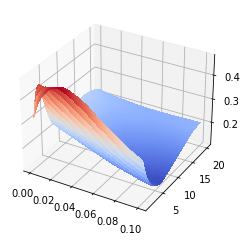

In [52]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X=A
Y=B
X, Y = np.meshgrid(X, Y)
Z=Liste_1_log
Z=np.array(Z)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

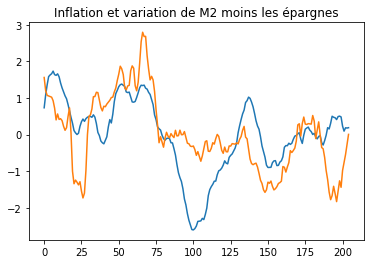

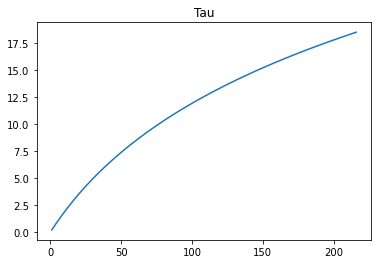

In [53]:
plt.figure()
plt.plot(delta_difference_1983_2001_standard_values,label='M')
plt.plot(inflation_shift_ideale_standard,label='inflation')
plt.title('Inflation et variation de M2 moins les épargnes')

plt.figure()
X=[x for x in range(1,217)]
Y = []
for x in X:
    Y.append(T(0.017,1,x))
plt.plot(X,Y)
plt.title('Tau')
plt.show()

In [54]:
### Construction du T idéal pour un décalage croissant ###

values = delta_difference_1983_2001_standard['M2_less_savings'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard['M2_less_savings'].values # Préparer les données
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.reshape((len(values), 1))
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.tolist()

for j in range(len(delta_difference_1983_2001_standard_values)):     
            delta_difference_1983_2001_standard_values[j] = delta_difference_1983_2001_standard_values[j][0]  # Mise au bon format

R_best_standard = 0
Solution_ideale_standard = [0,0,0]
Meilleurs_solutions_standard = []
inflation_shift_ideale_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

A = [0.001*i for i in range(1,101)]
B = [0.5*i for i in range(2,41)]
Liste_1_log = []

for b in B:
    L=[]

    for a in A:
        infla_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

        for i in range(len(delta_difference_1983_2001_standard_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla_standard[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        values = np.array(infla_standard)
        values = values.reshape((len(values), 1))
        scaler = scaler.fit(values)
        infla_standard = scaler.transform(values) #Standardisation de infla_standard
        infla_standard = infla_standard.tolist()

        for j in range(len(infla_standard)) :     # Mise au bon format
            infla_standard[j] = infla_standard[j][0]

        R = pearsonr(infla_standard,delta_difference_1983_2001_standard_values)
        
        if abs(R[0]) > 0.34 :
            Meilleurs_solutions_standard.append([a,b,R])

        if abs(R[0]) > abs(R_best_standard) :
            Solution_ideale_standard = [a,b,R]
            R_best_standard = R[0]
            inflation_shift_ideale_standard = infla_standard
        
        L.append(R[0])
    Liste_1_log.append(L)


print(Solution_ideale_standard)
#print(R_best_standard)
#print(Meilleurs_solutions_standard)

<ipython-input-54-5a428e7f9c6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_difference_1983_2001_standard['M2_less_savings'] = scaler.transform(values) # Standardisation de M
[0.029, 1.0, (0.4771478214609598, 4.721529077898239e-13)]
